<img style="float: right;vertical-align: top;" src="logo-see-with-tagline.png"/>
<font size="+2">KARI Science Orbit Analysis</font><br><br>
John Carrico: <a href="mailto:AstrogatorJohn@see.com">AstrogatorJohn@see.com</a>
<br>
<br>
This notebook runs the KPLO science orbit for about one year, performing station keeping maneuvers.<br>
The orbit is run for several different Longitude of the Ascending Node (LAN) values, and a graph is shown for each.

In [4]:
# Import Python Libraries

import numpy as np

import pandas as pd

#import scipy as sp

from datetime import datetime

import matplotlib

import matplotlib.pyplot as plt

# Error if you have a space: % matplotlib inline
%matplotlib inline 

from IPython.display import display, HTML

In [5]:
# Import Libraries to control STK

import os

import win32com.client as win32

import win32process

#from stk import AstrogatorOutput

In [6]:
stk_app = win32.DispatchEx("STK11.Application")
t, p = win32process.GetWindowThreadProcessId(stk_app.Hwnd)
# Start STK, or get handle if it's already running

#stk_app = win32.gencache.EnsureDispatch('STK11.Application')

#print(stk_app.__module__)

In [4]:
# Get pointers to the base objects

STK = stk_app.Personality # Personality is not used for this example, but used for Astrogator.

root = stk_app.Personality2

# Make it so we can see STK

stk_app.Visible = True

In [5]:
# Load scenerio (Note: Use forward slashes in the path names, not back slashes.)

repoPath = "C:/Users/macuser/SEE_bitbucket/see-python/"
notebookPath = "notebooks/KARI_ScienceOrbit/"
scenarioPath = "KARI Station Keeping Maneuver Analysis/StationKeepingManeuver.sc"
fullScenarioPath = "{}{}{}".format(repoPath,notebookPath,scenarioPath)

# If there is problem with the path having forward slashes, use normpath() to convert.
# (But on J. Carrico's Windows 10 Machine it didn't need it.)

#scenarioPath = os.path.normpath(scenarioPath)

print(fullScenarioPath)

root.LoadScenario(fullScenarioPath)
scenario = root.CurrentScenario

# Get pointer to the specified satellite

satelliteName = 'RotationOfLineOfApsides_100kmKPLO'

sat = scenario.Children(satelliteName)

C:/Users/jpcar/OneDrive/Documents/BitBucket/see-python/notebooks/KARI_ScienceOrbit/KARI Station Keeping Maneuver Analysis/StationKeepingManeuver.sc


In [6]:
# Get the satellite object
g_gatorDefn = STK.scenario(0).Satellite(satelliteName).GetAstrogatorDefn()

seg = g_gatorDefn.GetSegmentByName("Initial State")
endSeg = g_gatorDefn.GetSegmentByName("EndSeg")

# This line is an example to test
#propSeg.StoppingConditions[1].TripValue.Set(0.0, "deg")
seg.FinalState.Epoch.Format('UTCG').value,endSeg.FinalState.Epoch.Format('UTCG').value,

('22 Jan 2021 20:14:47.13000', '10 Dec 2021 06:46:23.21543')

In [7]:
print("Initial State:")
print("Element Type: {}".format(seg.ElementType.value))
print("Epoch {} UTC".format(seg.InitialState.Epoch.Format('UTCG').value))
print("SMA   {} km".format(seg.InitialState.Keplerian.sma.GetIn("km").value))
print("ECC   {} km".format(seg.InitialState.Keplerian.ecc.value))
print("INC   {} deg".format(seg.InitialState.Keplerian.inc.GetIn("deg").value))
print("LAN   {} deg".format(seg.InitialState.Keplerian.LAN.GetIn("deg").value))
print("LAN   {} deg".format(seg.InitialState.Keplerian.w.GetIn("deg").value))
print(" TA   {} deg".format(seg.InitialState.Keplerian.TA.GetIn("deg").value))

Initial State:
Element Type: Keplerian
Epoch 22 Jan 2021 20:14:47.13000 UTC
SMA   1836.5000000000027 km
ECC   0.015000000000000008 km
INC   89.7 deg
LAN   7.369547890803197e-10 deg
LAN   159.99999999999955 deg
 TA   7.69694232914171e-13 deg


In [8]:
# Set up Maneuver Summary Data Provider

# Set the units in which we want the data

root.UnitPreferences("DateFormat").SetCurrentUnit ("UTCG")
root.UnitPreferences("TimeUnit").SetCurrentUnit ("sec")

# get the data provider that we want
mnvrDataPrv = sat.DataProviders("Maneuver Summary")

# Create a list of the columns that we want from the report

mnvrDataColumns = []

# !!!!!!!!!!!!!!!!!!!!!!!!!
# Note that the columns seem to be returned according to the order in STK data providers, not in the order of this list.
# !!!!!!!!!!!!!!!!!!!!!!!!!

mnvrDataColumns.append("Maneuver Number")
mnvrDataColumns.append("Segment")
mnvrDataColumns.append("Start Time")
mnvrDataColumns.append("Delta V")

# Output this list
mnvrDataColumns

# Some Test Code
#result = mnvrDataPrv.ExecElements(seg.FinalState.Epoch.Format('UTCG').value,
#                              endSeg.FinalState.Epoch.Format('UTCG').value,
#                              mnvrDataColumns)

#if result.Message(0) == 'OK':
#    print("Report is OK")
#else:
#    print(result.Message(0))
    
#resultList = result.Value(0).DataSets(3).GetValues()
#np.sum(resultList),len(resultList),np.mean(resultList),np.std(resultList)

['Maneuver Number', 'Segment', 'Start Time', 'Delta V']

In [9]:
# Set up Polar Plot (Ecc vs TA) Data Provider

# Set the units in which we want the data

root.UnitPreferences("DateFormat").SetCurrentUnit ("UTCG")
root.UnitPreferences("TimeUnit").SetCurrentUnit ("min")

# get the data provider that we want
polarDataPrv = sat.DataProviders("Astrogator Values")
polarDataPrvGroup = polarDataPrv.Group.Item("Keplerian Elems")

# Create a list of the columns that we want from the report

polarDataColumns = []

# !!!!!!!!!!!!!!!!!!!!!!!!!
# Note that the columns seem to be returned according to the order in STK data providers, not in the order of this list.
# !!!!!!!!!!!!!!!!!!!!!!!!!

polarDataColumns.append("Time")
polarDataColumns.append("Lunar_TOD_Argument_of_Periapsis")
polarDataColumns.append("Lunar_TOD_Eccentricity")

# Output this list
polarDataColumns

['Time', 'Lunar_TOD_Argument_of_Periapsis', 'Lunar_TOD_Eccentricity']

In [10]:
# Create the list of LANs
start = 0.0
stop = 360
numruns = 9

lans = np.linspace(start,stop,num=numruns)
lans, list(range(numruns))

(array([   0.,   45.,   90.,  135.,  180.,  225.,  270.,  315.,  360.]),
 [0, 1, 2, 3, 4, 5, 6, 7, 8])

Started run: 2018-01-25 17:17:33.666253
Running LAN = 0.0
Number of Maneuvers: 12
Total Delta-V: 122.07502805123306 (m/s)
Mean Delta-V: 10.172919004269422 (m/s)
Standard Deviation of Delta-V: 1.2690694185703486 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,27 Mar 2021 04:39:01.756125467,9.625095
1,2,Sequence0.Target_Sequence.Mnvr_2,27 Mar 2021 07:40:38.208624830,9.469614
2,3,Sequence1.Target_Sequence.Mnvr_1,17 Jun 2021 02:39:07.876870008,10.767997
3,4,Sequence1.Target_Sequence.Mnvr_2,17 Jun 2021 05:39:49.549989175,10.698265
4,5,Sequence2.Target_Sequence.Mnvr_1,7 Sep 2021 02:52:49.392549545,10.687507
5,6,Sequence2.Target_Sequence.Mnvr_2,7 Sep 2021 05:53:24.578899350,10.609623
6,7,Sequence3.Target_Sequence.Mnvr_1,28 Nov 2021 03:19:26.661337569,10.640823
7,8,Sequence3.Target_Sequence.Mnvr_2,28 Nov 2021 06:19:55.786976136,10.548711
8,9,Sequence4.Target_Sequence.Mnvr_1,2 Mar 2022 00:31:31.142256163,11.577833
9,10,Sequence4.Target_Sequence.Mnvr_2,2 Mar 2022 03:33:30.959446646,11.775865


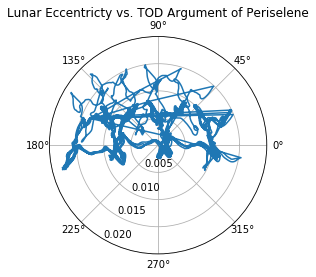

Current Time: 2018-01-25 17:25:40.276053; Elapsed Time: 8.110163333333334 minutes
Running LAN = 45.0
Number of Maneuvers: 12
Total Delta-V: 102.09028599265774 (m/s)
Mean Delta-V: 8.507523832721478 (m/s)
Standard Deviation of Delta-V: 3.5911710081611283 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,23 Feb 2021 21:29:16.377942094,4.686136
1,2,Sequence0.Target_Sequence.Mnvr_2,24 Feb 2021 00:29:04.824186331,4.649788
2,3,Sequence1.Target_Sequence.Mnvr_1,10 May 2021 03:32:19.244165260,12.029910
3,4,Sequence1.Target_Sequence.Mnvr_2,10 May 2021 06:33:59.584166626,11.733200
4,5,Sequence2.Target_Sequence.Mnvr_1,13 Jun 2021 14:05:09.198495284,5.185340
5,6,Sequence2.Target_Sequence.Mnvr_2,13 Jun 2021 17:06:30.668235637,5.386162
6,7,Sequence3.Target_Sequence.Mnvr_1,27 Aug 2021 10:31:17.847993679,12.126688
7,8,Sequence3.Target_Sequence.Mnvr_2,27 Aug 2021 13:34:14.384413417,11.855581
8,9,Sequence4.Target_Sequence.Mnvr_1,30 Sep 2021 19:08:40.170838520,5.175606
9,10,Sequence4.Target_Sequence.Mnvr_2,30 Sep 2021 22:10:00.328615695,5.381535


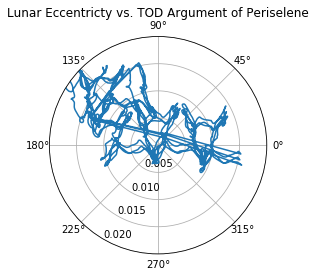

Current Time: 2018-01-25 17:32:39.587688; Elapsed Time: 15.098690583333333 minutes
Running LAN = 90.0
Number of Maneuvers: 12
Total Delta-V: 115.10181486796762 (m/s)
Mean Delta-V: 9.591817905663968 (m/s)
Standard Deviation of Delta-V: 2.223577243415132 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,27 Feb 2021 19:46:43.113750604,5.417398
1,2,Sequence0.Target_Sequence.Mnvr_2,27 Feb 2021 22:48:47.985069733,5.582692
2,3,Sequence1.Target_Sequence.Mnvr_1,13 May 2021 06:06:25.369223589,11.635321
3,4,Sequence1.Target_Sequence.Mnvr_2,13 May 2021 09:09:08.912958562,11.828244
4,5,Sequence2.Target_Sequence.Mnvr_1,24 Jun 2021 04:04:18.596852174,8.289731
5,6,Sequence2.Target_Sequence.Mnvr_2,24 Jun 2021 07:05:07.909857925,8.045912
6,7,Sequence3.Target_Sequence.Mnvr_1,14 Sep 2021 01:03:35.699686788,10.820432
7,8,Sequence3.Target_Sequence.Mnvr_2,14 Sep 2021 04:04:20.242435217,10.749154
8,9,Sequence4.Target_Sequence.Mnvr_1,5 Dec 2021 02:18:06.025992930,10.758808
9,10,Sequence4.Target_Sequence.Mnvr_2,5 Dec 2021 05:18:51.954921205,10.684495


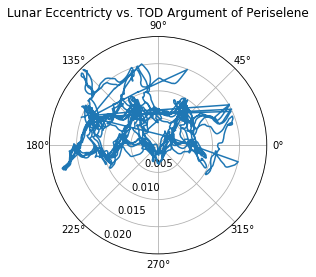

Current Time: 2018-01-25 17:40:18.314544; Elapsed Time: 22.744138183333334 minutes
Running LAN = 135.0
Number of Maneuvers: 12
Total Delta-V: 128.92034676468114 (m/s)
Mean Delta-V: 10.743362230390096 (m/s)
Standard Deviation of Delta-V: 0.6033015903500364 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,9 Mar 2021 16:57:52.054848756,9.386091
1,2,Sequence0.Target_Sequence.Mnvr_2,9 Mar 2021 19:59:22.371916101,9.597534
2,3,Sequence1.Target_Sequence.Mnvr_1,30 May 2021 11:43:59.296993019,10.876953
3,4,Sequence1.Target_Sequence.Mnvr_2,30 May 2021 14:44:41.574101770,11.229757
4,5,Sequence2.Target_Sequence.Mnvr_1,20 Aug 2021 07:13:03.637524720,11.160357
5,6,Sequence2.Target_Sequence.Mnvr_2,20 Aug 2021 10:13:41.651274826,11.058524
6,7,Sequence3.Target_Sequence.Mnvr_1,10 Nov 2021 01:01:53.251117706,11.121120
7,8,Sequence3.Target_Sequence.Mnvr_2,10 Nov 2021 04:02:25.136290379,11.007318
8,9,Sequence4.Target_Sequence.Mnvr_1,30 Jan 2022 03:31:17.688316427,10.909260
9,10,Sequence4.Target_Sequence.Mnvr_2,30 Jan 2022 06:31:28.825150900,10.744755


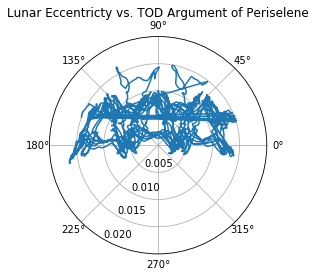

Current Time: 2018-01-25 17:49:36.675502; Elapsed Time: 32.05015415 minutes
Running LAN = 180.0
Number of Maneuvers: 12
Total Delta-V: 127.68399859126322 (m/s)
Mean Delta-V: 10.640333215938602 (m/s)
Standard Deviation of Delta-V: 0.3798064090347254 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,1 Apr 2021 13:53:41.463099347,10.454961
1,2,Sequence0.Target_Sequence.Mnvr_2,1 Apr 2021 16:52:53.780854383,10.662520
2,3,Sequence1.Target_Sequence.Mnvr_1,3 Jun 2021 11:37:33.788518919,9.719283
3,4,Sequence1.Target_Sequence.Mnvr_2,3 Jun 2021 14:38:55.578568492,10.053782
4,5,Sequence2.Target_Sequence.Mnvr_1,24 Aug 2021 02:57:22.022270612,10.879764
5,6,Sequence2.Target_Sequence.Mnvr_2,24 Aug 2021 05:57:57.797017220,10.812117
6,7,Sequence3.Target_Sequence.Mnvr_1,13 Nov 2021 22:26:00.688891377,10.878157
7,8,Sequence3.Target_Sequence.Mnvr_2,14 Nov 2021 01:26:41.515007094,10.808973
8,9,Sequence4.Target_Sequence.Mnvr_1,3 Feb 2022 20:03:18.073918290,10.902046
9,10,Sequence4.Target_Sequence.Mnvr_2,3 Feb 2022 23:04:00.448574603,10.831398


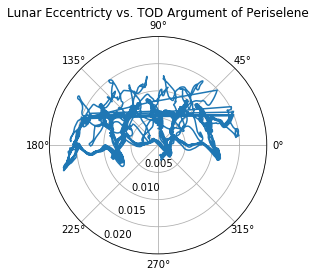

Current Time: 2018-01-25 17:58:20.702339; Elapsed Time: 40.78393476666667 minutes
Running LAN = 225.0
Number of Maneuvers: 12
Total Delta-V: 130.42710253020817 (m/s)
Mean Delta-V: 10.868925210850682 (m/s)
Standard Deviation of Delta-V: 0.12169880244577647 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,12 Apr 2021 22:53:08.387755578,10.776452
1,2,Sequence0.Target_Sequence.Mnvr_2,13 Apr 2021 01:54:20.130415998,10.685107
2,3,Sequence1.Target_Sequence.Mnvr_1,3 Jul 2021 20:51:40.511481954,11.009795
3,4,Sequence1.Target_Sequence.Mnvr_2,3 Jul 2021 23:52:42.109418465,10.929952
4,5,Sequence2.Target_Sequence.Mnvr_1,23 Sep 2021 19:03:22.627586175,10.729584
5,6,Sequence2.Target_Sequence.Mnvr_2,23 Sep 2021 22:04:20.636171155,11.096600
6,7,Sequence3.Target_Sequence.Mnvr_1,14 Dec 2021 17:48:33.529158726,10.973781
7,8,Sequence3.Target_Sequence.Mnvr_2,14 Dec 2021 20:49:26.487181183,10.898429
8,9,Sequence4.Target_Sequence.Mnvr_1,6 Mar 2022 16:45:21.858684562,10.896015
9,10,Sequence4.Target_Sequence.Mnvr_2,6 Mar 2022 19:46:12.492323995,10.823838


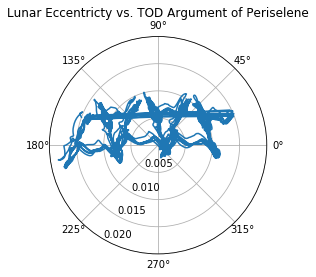

Current Time: 2018-01-25 18:06:34.683869; Elapsed Time: 49.016960266666665 minutes
Running LAN = 270.0
Number of Maneuvers: 12
Total Delta-V: 123.32203189607193 (m/s)
Mean Delta-V: 10.276835991339327 (m/s)
Standard Deviation of Delta-V: 2.297198047885974 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,15 Apr 2021 08:00:00.267347017,10.771513
1,2,Sequence0.Target_Sequence.Mnvr_2,15 Apr 2021 11:00:07.350861700,11.032510
2,3,Sequence1.Target_Sequence.Mnvr_1,5 Jul 2021 15:14:38.375695433,10.756498
3,4,Sequence1.Target_Sequence.Mnvr_2,5 Jul 2021 18:14:54.346038012,10.968247
4,5,Sequence2.Target_Sequence.Mnvr_1,25 Sep 2021 09:25:04.038915116,10.869068
5,6,Sequence2.Target_Sequence.Mnvr_2,25 Sep 2021 12:24:58.989203975,11.085978
6,7,Sequence3.Target_Sequence.Mnvr_1,5 Dec 2021 08:01:26.653464511,11.751806
7,8,Sequence3.Target_Sequence.Mnvr_2,5 Dec 2021 11:03:47.871382628,11.423543
8,9,Sequence4.Target_Sequence.Mnvr_1,7 Jan 2022 02:32:34.599323232,5.324137
9,10,Sequence4.Target_Sequence.Mnvr_2,7 Jan 2022 05:33:59.977968097,5.560356


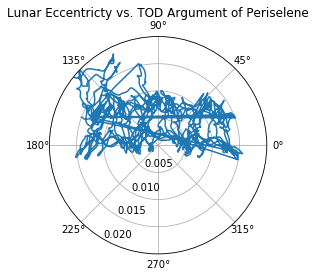

Current Time: 2018-01-25 18:14:00.706504; Elapsed Time: 56.45067085 minutes
Running LAN = 315.0
Number of Maneuvers: 12
Total Delta-V: 104.4761852879616 (m/s)
Mean Delta-V: 8.7063487739968 (m/s)
Standard Deviation of Delta-V: 3.393801116140387 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,6 Apr 2021 07:34:40.004665693,12.084185
1,2,Sequence0.Target_Sequence.Mnvr_2,6 Apr 2021 10:36:13.127790947,11.750222
2,3,Sequence1.Target_Sequence.Mnvr_1,9 May 2021 20:36:25.899069130,5.552703
3,4,Sequence1.Target_Sequence.Mnvr_2,9 May 2021 23:38:00.217815388,5.485556
4,5,Sequence2.Target_Sequence.Mnvr_1,24 Jul 2021 09:48:37.352107182,12.147654
5,6,Sequence2.Target_Sequence.Mnvr_2,24 Jul 2021 12:50:33.184136216,11.828058
6,7,Sequence3.Target_Sequence.Mnvr_1,27 Aug 2021 03:16:27.877548996,5.478272
7,8,Sequence3.Target_Sequence.Mnvr_2,27 Aug 2021 06:18:00.532808702,5.418861
8,9,Sequence4.Target_Sequence.Mnvr_1,10 Nov 2021 15:35:28.635669943,12.112793
9,10,Sequence4.Target_Sequence.Mnvr_2,10 Nov 2021 18:37:44.825707577,11.795296


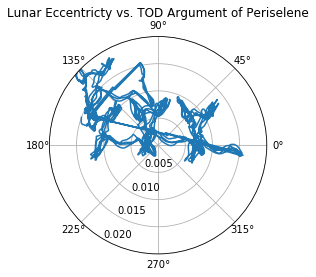

Current Time: 2018-01-25 18:23:15.691779; Elapsed Time: 65.70042543333334 minutes
Running LAN = 360.0
Number of Maneuvers: 12
Total Delta-V: 122.07503092510652 (m/s)
Mean Delta-V: 10.172919243758876 (m/s)
Standard Deviation of Delta-V: 1.269068958658663 (m/s)


,Maneuver Number,Segment,Start Time,Delta V
0,1,Sequence0.Target_Sequence.Mnvr_1,27 Mar 2021 04:39:01.767428156,9.625095
1,2,Sequence0.Target_Sequence.Mnvr_2,27 Mar 2021 07:40:38.203741761,9.469613
2,3,Sequence1.Target_Sequence.Mnvr_1,17 Jun 2021 02:39:07.826796880,10.767998
3,4,Sequence1.Target_Sequence.Mnvr_2,17 Jun 2021 05:39:49.516049685,10.698264
4,5,Sequence2.Target_Sequence.Mnvr_1,7 Sep 2021 02:52:49.326680426,10.687507
5,6,Sequence2.Target_Sequence.Mnvr_2,7 Sep 2021 05:53:24.513357103,10.609623
6,7,Sequence3.Target_Sequence.Mnvr_1,28 Nov 2021 03:19:26.595960405,10.640822
7,8,Sequence3.Target_Sequence.Mnvr_2,28 Nov 2021 06:19:55.675747309,10.548713
8,9,Sequence4.Target_Sequence.Mnvr_1,2 Mar 2022 00:31:30.980197839,11.577832
9,10,Sequence4.Target_Sequence.Mnvr_2,2 Mar 2022 03:33:30.807189532,11.775865


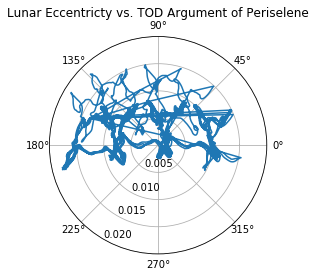

Current Time: 2018-01-25 18:31:32.810539; Elapsed Time: 73.98573809999999 minutes


In [11]:
# Loop through the list of LANs and run the MCS for each. 
# Save the summary data in arrays; Plot a graph and display the maneuvers for each LAN run.

numMnvrs = [0.0 for x in range(numruns)]
totalDV = [0.0 for x in range(numruns)]
meanDV = [0.0 for x in range(numruns)]
stdDV = [0.0 for x in range(numruns)]

# Start the timer so we know how long this took to run.
startTime = datetime.now()
print("Started run: {}".format(str(startTime)))

# Loop through the LANs:

for lan,i in zip(lans,range(numruns)):
    print("Running LAN = {}".format(lan))
    tf = seg.InitialState.Keplerian.LAN.Set(lan, "deg")
    tf = g_gatorDefn.RunMCS()
    #Get the Maneuver Results and put them in a Pandas dataframe
    mnvrResult = mnvrDataPrv.ExecElements(seg.FinalState.Epoch.Format('UTCG').value,
                                          endSeg.FinalState.Epoch.Format('UTCG').value,
                                          mnvrDataColumns)
    if mnvrResult.Message(0) == 'OK':
        # Put the results into a Pandas dataframe
        mnvrReportDF = pd.DataFrame()
        j = 0
        for colName in mnvrDataColumns:
            mnvrReportDF[colName]= list(mnvrResult.Value(0).DataSets(j).GetValues())
            j = j + 1
        numMnvrs[i] = mnvrReportDF['Delta V'].count()
        totalDV[i] = mnvrReportDF['Delta V'].sum()
        meanDV[i] = mnvrReportDF['Delta V'].mean()
        stdDV[i] = mnvrReportDF['Delta V'].std()
        #resultList = mnvrResult.Value(0).DataSets(3).GetValues()
        #numMnvrs[i] = len(resultList)
        #totalDV[i] = np.sum(resultList)
        #meanDV[i] = np.mean(resultList)
        #stdDV[i] = np.std(resultList)
        print("Number of Maneuvers: {}".format(numMnvrs[i]))
        print("Total Delta-V: {} (m/s)".format(totalDV[i]))
        print("Mean Delta-V: {} (m/s)".format(meanDV[i]))
        print("Standard Deviation of Delta-V: {} (m/s)".format(stdDV[i] ))
        display(mnvrReportDF)
    # Get the Polar results and put them into a Pandas dataframe
    polarResult = polarDataPrvGroup.ExecElements(seg.FinalState.Epoch.Format('UTCG').value,
                                                endSeg.FinalState.Epoch.Format('UTCG').value, 
                                                120, polarDataColumns)
    if polarResult.Message(0) == 'OK':
        polarReportDF = pd.DataFrame()
        j = 0
        for colName in polarDataColumns:
            polarReportDF[colName]= list(polarResult.Value(0).DataSets(j).GetValues())
            j = j + 1
        # Display a polar plot: Ecc vs. TA
        ax = plt.subplot(111, projection='polar')
        ax.plot(np.deg2rad(polarReportDF["Lunar_TOD_Argument_of_Periapsis"]), polarReportDF["Lunar_TOD_Eccentricity"])
        ax.set_rmax(0.02)
        ax.set_rticks([0.005,0.010,0.015, 0.020])  # less radial ticks
        ax.set_rlabel_position(240)  # get radial labels away from plotted line
        ax.grid(True)
        ax.set_title("Lunar Eccentricty vs. TOD Argument of Periselene", va='bottom')
        plt.show()
        # Display the time and elasped time
        stopTime = datetime.now()
        elapsedTime = (stopTime-startTime)
        print("Current Time: {}; Elapsed Time: {} minutes".format(str(stopTime),elapsedTime.total_seconds()/60.0))

In [12]:
# Create a dataframe for the summary data
summaryReportDF = pd.DataFrame()
summaryReportDF['LAN (deg)'] = lans
summaryReportDF['Number Maneuvers'] = numMnvrs
summaryReportDF['Total Delta V (m/s)'] = totalDV
summaryReportDF['Mean Delta V (m/s)'] = meanDV
summaryReportDF['Standard Deviation (m/s)'] = stdDV
summaryReportDF

,LAN (deg),Number Maneuvers,Total Delta V (m/s),Mean Delta V (m/s),Standard Deviation (m/s)
0,0.0,12,122.075028,10.172919,1.269069
1,45.0,12,102.090286,8.507524,3.591171
2,90.0,12,115.101815,9.591818,2.223577
3,135.0,12,128.920347,10.743362,0.603302
4,180.0,12,127.683999,10.640333,0.379806
5,225.0,12,130.427103,10.868925,0.121699
6,270.0,12,123.322032,10.276836,2.297198
7,315.0,12,104.476185,8.706349,3.393801
8,360.0,12,122.075031,10.172919,1.269069


In [13]:
summaryReportDF.to_csv('Summary_Report 100 km-75x75.csv')